In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os

In [3]:
tcga= pd.read_csv("uploads_tcga-brca-final.csv")

In [4]:
tcga=tcga.set_index("samples")

In [5]:
tcga

,ARHGEF10L,HIF3A,RNF17,RNF10,RNF11,RNF13,GTF2IP1,REM1,MTVR2,RTN4RL2,...,DSS.time,DFI,DFI.time,PFI,PFI.time,Redaction,sample_type_id,sample_type,_primary_disease,combined_stage
samples,,,,,,,,,,,,,,,,,,,,,
TCGA-E2-A15K-06,9.5115,2.2342,0.0000,11.9525,11.1009,10.1532,13.1496,3.6768,0.0000,6.6778,...,275.0,0.000000,275.000000,0.0,275.0,0,6.0,0,0,0
TCGA-AC-A6IX-06,9.8322,5.5864,0.6543,11.8572,11.4146,10.7002,12.6255,5.4699,0.6543,6.6393,...,373.0,0.000000,373.000000,0.0,373.0,0,6.0,0,0,1
TCGA-BH-A18V-06,10.3288,9.0009,1.1120,11.4478,10.4904,10.5517,12.9269,3.8142,0.6606,5.1868,...,1556.0,0.000000,1556.000000,0.0,1556.0,0,6.0,0,0,0
TCGA-E2-A15A-06,9.2990,2.0152,0.3833,11.8497,10.4959,10.0438,12.6822,4.8114,0.0000,4.0459,...,710.0,0.000000,710.000000,0.0,710.0,0,6.0,0,0,1
TCGA-E2-A15E-06,9.3333,3.8639,0.0000,11.9488,11.5201,10.1137,12.5709,4.1040,0.0000,4.3897,...,630.0,0.000000,630.000000,0.0,630.0,0,6.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-A7-A26E-01,9.6430,3.2869,0.0000,12.0723,11.7878,10.5635,12.7208,3.0760,0.6144,4.1038,...,954.0,0.000000,954.000000,0.0,954.0,0,1.0,1,0,1
TCGA-A7-A13E-01,10.7570,3.0461,0.0000,11.1565,10.7619,10.3025,12.9691,5.2856,0.0000,7.6592,...,614.0,1.000000,556.000000,1.0,556.0,0,1.0,1,0,0
TCGA-A7-A0DB-01,9.4012,3.9239,0.0000,11.9896,11.4222,10.7523,12.7633,3.5041,0.0000,6.0723,...,1007.0,0.087669,1172.677917,0.0,1007.0,0,1.0,1,0,0


In [6]:
with open("categorical_mappings.json", "r") as json_file:
    categorical_mappings = json.load(json_file)

In [7]:
categorical_mappings

{'sample': {'TCGA-E2-A15K-06': 0,
  'TCGA-AC-A6IX-06': 1,
  'TCGA-BH-A18V-06': 2,
  'TCGA-E2-A15A-06': 3,
  'TCGA-E2-A15E-06': 4,
  'TCGA-BH-A1ES-06': 5,
  'TCGA-BH-A1FE-06': 6,
  'TCGA-AO-A1KQ-01': 7,
  'TCGA-E2-A14W-01': 8,
  'TCGA-A1-A0SM-01': 9,
  'TCGA-AR-A1AV-01': 10,
  'TCGA-BH-A0B4-01': 11,
  'TCGA-EW-A1PD-01': 12,
  'TCGA-EW-A6SA-01': 13,
  'TCGA-AC-A62V-01': 14,
  'TCGA-BH-A0DD-01': 15,
  'TCGA-AQ-A54O-01': 16,
  'TCGA-D8-A1XS-01': 17,
  'TCGA-A8-A085-01': 18,
  'TCGA-A2-A25D-01': 19,
  'TCGA-AC-A23H-01': 20,
  'TCGA-AC-A3W6-01': 21,
  'TCGA-B6-A0IC-01': 22,
  'TCGA-BH-A1F8-01': 23,
  'TCGA-C8-A26Y-01': 24,
  'TCGA-D8-A1JK-01': 25,
  'TCGA-E2-A9RU-01': 26,
  'TCGA-LL-A6FP-01': 27,
  'TCGA-A8-A08A-01': 28,
  'TCGA-A8-A08L-01': 29,
  'TCGA-E2-A15O-01': 30,
  'TCGA-AN-A0FK-01': 31,
  'TCGA-BH-A18N-01': 32,
  'TCGA-BH-A1FG-01': 33,
  'TCGA-D8-A73U-01': 34,
  'TCGA-LL-A5YM-01': 35,
  'TCGA-AC-A2FM-01': 36,
  'TCGA-AC-A3HN-01': 37,
  'TCGA-BH-A8FY-01': 38,
  'TCGA-D8-A1XG-01': 39,


### GSEA on TCGA dataset using T-Tests and Wilcoxon

In [8]:
X=tcga.iloc[:, :20530]
valid_features = (X.mean(axis=0) > 0)
X = X.loc[:, valid_features]
X_new = X.loc[:, (X != X.iloc[0]).any()]

In [9]:
X

,ARHGEF10L,HIF3A,RNF17,RNF10,RNF11,RNF13,GTF2IP1,REM1,MTVR2,RTN4RL2,...,TULP2,NPY5R,GNGT2,GNGT1,TULP3,PTRF,BCL6B,GSTK1,SELP,SELS
samples,,,,,,,,,,,,,,,,,,,,,
TCGA-E2-A15K-06,9.5115,2.2342,0.0000,11.9525,11.1009,10.1532,13.1496,3.6768,0.0000,6.6778,...,0.7430,9.6516,3.3354,0.0000,9.0140,9.3414,6.4633,10.7865,5.9767,9.6956
TCGA-AC-A6IX-06,9.8322,5.5864,0.6543,11.8572,11.4146,10.7002,12.6255,5.4699,0.6543,6.6393,...,0.0000,5.3328,5.3833,1.7203,9.1207,11.8037,7.5283,10.7332,8.1693,10.2417
TCGA-BH-A18V-06,10.3288,9.0009,1.1120,11.4478,10.4904,10.5517,12.9269,3.8142,0.6606,5.1868,...,0.3678,2.0683,5.7739,0.0000,9.6202,12.0974,7.6071,11.6139,5.3903,10.3078
TCGA-E2-A15A-06,9.2990,2.0152,0.3833,11.8497,10.4959,10.0438,12.6822,4.8114,0.0000,4.0459,...,0.9357,4.7475,4.7637,3.7844,9.1685,11.1935,7.3926,12.0764,8.4334,9.7166
TCGA-E2-A15E-06,9.3333,3.8639,0.0000,11.9488,11.5201,10.1137,12.5709,4.1040,0.0000,4.3897,...,0.4611,4.8888,4.1958,2.4646,8.7856,9.7641,5.8071,11.7569,6.3505,9.8414
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-A7-A26E-01,9.6430,3.2869,0.0000,12.0723,11.7878,10.5635,12.7208,3.0760,0.6144,4.1038,...,0.0000,1.0440,3.8081,0.3397,9.4005,11.7000,7.9504,10.9232,6.0796,9.5597
TCGA-A7-A13E-01,10.7570,3.0461,0.0000,11.1565,10.7619,10.3025,12.9691,5.2856,0.0000,7.6592,...,0.0000,1.1897,2.6146,0.0000,10.7121,12.3077,7.5614,11.4325,2.6146,9.8387
TCGA-A7-A0DB-01,9.4012,3.9239,0.0000,11.9896,11.4222,10.7523,12.7633,3.5041,0.0000,6.0723,...,1.1040,2.9813,4.9310,0.0000,8.7449,12.5592,7.8173,11.5188,7.4414,9.6785


In [10]:
y=tcga["combined_stage"]
stage_mapping = {v: k for k, v in categorical_mappings["combined_stage"].items()}
y_decoded = y.map(stage_mapping)

In [11]:
tcga["combined_stage"]=y_decoded

In [12]:
tcga

,ARHGEF10L,HIF3A,RNF17,RNF10,RNF11,RNF13,GTF2IP1,REM1,MTVR2,RTN4RL2,...,DSS.time,DFI,DFI.time,PFI,PFI.time,Redaction,sample_type_id,sample_type,_primary_disease,combined_stage
samples,,,,,,,,,,,,,,,,,,,,,
TCGA-E2-A15K-06,9.5115,2.2342,0.0000,11.9525,11.1009,10.1532,13.1496,3.6768,0.0000,6.6778,...,275.0,0.000000,275.000000,0.0,275.0,0,6.0,0,0,Stage II
TCGA-AC-A6IX-06,9.8322,5.5864,0.6543,11.8572,11.4146,10.7002,12.6255,5.4699,0.6543,6.6393,...,373.0,0.000000,373.000000,0.0,373.0,0,6.0,0,0,Stage III
TCGA-BH-A18V-06,10.3288,9.0009,1.1120,11.4478,10.4904,10.5517,12.9269,3.8142,0.6606,5.1868,...,1556.0,0.000000,1556.000000,0.0,1556.0,0,6.0,0,0,Stage II
TCGA-E2-A15A-06,9.2990,2.0152,0.3833,11.8497,10.4959,10.0438,12.6822,4.8114,0.0000,4.0459,...,710.0,0.000000,710.000000,0.0,710.0,0,6.0,0,0,Stage III
TCGA-E2-A15E-06,9.3333,3.8639,0.0000,11.9488,11.5201,10.1137,12.5709,4.1040,0.0000,4.3897,...,630.0,0.000000,630.000000,0.0,630.0,0,6.0,0,0,Stage II
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-A7-A26E-01,9.6430,3.2869,0.0000,12.0723,11.7878,10.5635,12.7208,3.0760,0.6144,4.1038,...,954.0,0.000000,954.000000,0.0,954.0,0,1.0,1,0,Stage III
TCGA-A7-A13E-01,10.7570,3.0461,0.0000,11.1565,10.7619,10.3025,12.9691,5.2856,0.0000,7.6592,...,614.0,1.000000,556.000000,1.0,556.0,0,1.0,1,0,Stage II
TCGA-A7-A0DB-01,9.4012,3.9239,0.0000,11.9896,11.4222,10.7523,12.7633,3.5041,0.0000,6.0723,...,1007.0,0.087669,1172.677917,0.0,1007.0,0,1.0,1,0,Stage II


In [13]:
tcga["combined_stage"].value_counts()

combined_stage
Stage II         625
Stage III        251
Stage I          182
Normal           113
Stage IV          33
[Discrepancy]      6
Unknown            5
Name: count, dtype: int64

In [14]:
from scipy.stats import mannwhitneyu
import numpy as np
import pandas as pd

def perform_wilcoxon_test(X, y, group1, group2):

    X_group1 = X[y == group1]
    X_group2 = X[y == group2]
    combined_metrics = []
    p_values = []
    log_fold_changes = []

    for feature in X.columns:
        group1_feature = X_group1[feature].dropna()
        group2_feature = X_group2[feature].dropna()

        if len(group1_feature) > 0 and len(group2_feature) > 0:
            _, p_value = mannwhitneyu(group1_feature, group2_feature, alternative='two-sided')
            
            mean_group1 = group1_feature.mean()
            mean_group2 = group2_feature.mean()
            
            # Calculate log fold change if means are non-zero
            if mean_group1 > 0 and mean_group2 > 0:
                log_fc = np.log2(mean_group1 / mean_group2)
            else:
                log_fc = np.nan
            
            # Compute the combined metric: -log10(p-value) * sign(log2FC)
            if not np.isnan(log_fc):
                combined_metric = -np.log10(p_value) * np.sign(log_fc)
            else:
                combined_metric = np.nan
        else:
            p_value, log_fc, combined_metric = np.nan, np.nan, np.nan

        p_values.append(p_value)
        log_fold_changes.append(log_fc)
        combined_metrics.append(combined_metric)

    results = pd.DataFrame({
        'Feature': X.columns,
        'P-Value': p_values,
        'Log2FC': log_fold_changes,
        'Combined Metric': combined_metrics,
    }).dropna().sort_values(by='Combined Metric', ascending=False) 

    return results



In [38]:

comparisons = [
    ('Stage I','Normal'),
    ('Stage II','Normal'),
    ('Stage I', 'Stage II')
 
]


results = {}

for group1, group2 in comparisons:
    print(f"Processing comparison: {group1} vs. {group2}")
    filtered_data = tcga[tcga['combined_stage'].isin([group1, group2])]
    X_filtered = filtered_data.iloc[:,:20530]
    X_new = X_filtered.loc[:, (X_filtered != X_filtered.iloc[0]).any()]
    y_filtered = filtered_data['combined_stage']
    wil_results =perform_wilcoxon_test(X_new, y_filtered, group1, group2)

    results[f'{group1}_vs_{group2}'] = {
        'T-Test Results': wil_results
    }
stage1_vs_normal_results = results['Stage I_vs_Normal']
t_test_df = stage1_vs_normal_results['T-Test Results']

Processing comparison: Stage I vs. Normal
Processing comparison: Stage II vs. Normal
Processing comparison: Stage I vs. Stage II


In [39]:
t_test_df

,Feature,P-Value,Log2FC,Combined Metric
12735,MMP11,1.449849e-46,0.932911,45.838677
2774,COL10A1,2.765840e-46,1.497477,45.558173
12571,IBSP,1.409568e-44,3.921392,43.850914
12421,SLC35A2,1.405612e-43,0.176252,42.852135
14381,CKS2,2.245191e-43,0.422745,42.648747
...,...,...,...,...
12882,LMOD1,1.704229e-46,-0.434764,-45.768472
2722,SDPR,1.571964e-46,-0.715892,-45.803557
4279,FIGF,1.477493e-46,-1.520883,-45.830474
17662,SCN4B,1.114609e-46,-0.504444,-45.952877


In [40]:
stage2_vs_normal_results = results['Stage II_vs_Normal']

In [41]:
stage2_vs_normal_results['T-Test Results']

,Feature,P-Value,Log2FC,Combined Metric
12797,MMP11,1.720835e-62,0.910608,61.764261
10785,NEK2,1.344425e-61,1.105465,60.871463
7194,UBE2T,6.536247e-61,0.680253,60.184672
12378,PKMYT1,2.156896e-60,1.173982,59.666171
14451,CKS2,2.585856e-60,0.465410,59.587396
...,...,...,...,...
2736,SDPR,3.580490e-63,-0.811582,-62.446058
4301,FIGF,3.236021e-63,-1.653288,-62.489989
7978,CA4,4.027567e-64,-2.601378,-63.394957
5447,LOC572558,3.046814e-64,-2.699219,-63.516154


In [42]:
stage1_vs_stage2_results = results['Stage I_vs_Stage II']

In [43]:
stage1_vs_stage2_results['T-Test Results']

,Feature,P-Value,Log2FC,Combined Metric
18736,CYBRD1,1.907916e-07,0.077278,6.719441
18716,DARC,2.239179e-07,0.221827,6.649911
8750,RASL11A,3.902026e-07,0.117330,6.408710
7570,PHYHD1,6.249509e-07,0.189200,6.204154
6836,FCER1A,7.535250e-07,0.234260,6.122902
...,...,...,...,...
4645,SGOL1,7.863783e-07,-0.137525,-6.104368
15288,TTK,7.633979e-07,-0.102964,-6.117249
2151,FAM72B,4.476766e-07,-0.120717,-6.349036
16631,PBK,2.058222e-07,-0.106108,-6.686508


##### Thresholding

In [44]:
def thresh(df):
    logfc_threshold = 0.5
    pval_threshold = 0.05
    
    # Filter genes
    filtered_genes = df[
        (abs(df['Log2FC']) >= logfc_threshold) &  # Magnitude of log fold change
        (df['P-Value'] <= pval_threshold)       # Significance threshold
    ]
    return filtered_genes

In [45]:
stage1_vs_normal=thresh(stage1_vs_normal_results['T-Test Results'])

In [46]:
stage1_vs_normal

,Feature,P-Value,Log2FC,Combined Metric
12735,MMP11,1.449849e-46,0.932911,45.838677
2774,COL10A1,2.765840e-46,1.497477,45.558173
12571,IBSP,1.409568e-44,3.921392,43.850914
10727,NEK2,2.523604e-43,1.021532,42.597979
10793,BMP8A,9.446203e-43,0.554312,42.024743
...,...,...,...,...
18698,MAMDC2,6.699947e-46,-0.671755,-45.173929
2722,SDPR,1.571964e-46,-0.715892,-45.803557
4279,FIGF,1.477493e-46,-1.520883,-45.830474
17662,SCN4B,1.114609e-46,-0.504444,-45.952877


In [47]:
stage2_vs_normal=thresh(stage2_vs_normal_results['T-Test Results'])

In [48]:
stage2_vs_normal

,Feature,P-Value,Log2FC,Combined Metric
12797,MMP11,1.720835e-62,0.910608,61.764261
10785,NEK2,1.344425e-61,1.105465,60.871463
7194,UBE2T,6.536247e-61,0.680253,60.184672
12378,PKMYT1,2.156896e-60,1.173982,59.666171
1041,ASF1B,4.971181e-60,0.618314,59.303540
...,...,...,...,...
2736,SDPR,3.580490e-63,-0.811582,-62.446058
4301,FIGF,3.236021e-63,-1.653288,-62.489989
7978,CA4,4.027567e-64,-2.601378,-63.394957
5447,LOC572558,3.046814e-64,-2.699219,-63.516154


In [49]:
stage1_vs_stage2=thresh(stage1_vs_stage2_results['T-Test Results'])

In [50]:
stage1_vs_stage2

,Feature,P-Value,Log2FC,Combined Metric
2249,KLK3,0.000034,0.549925,4.468933
3935,UCP1,0.000069,0.601934,4.159818
7978,CA4,0.000123,0.508433,3.908654
10801,NPY2R,0.000149,0.551874,3.827208
8134,SNORA9,0.000299,1.163698,3.524321
...,...,...,...,...
15410,MAGEA3,0.000260,-1.062847,-3.584355
572,CPLX3,0.000259,-0.508310,-3.586670
343,RTBDN,0.000248,-0.503079,-3.604872
6401,LHX1,0.000241,-1.100046,-3.617387


##### GSEA

In [67]:
gsea_1_2= stage1_vs_stage2_results[['Feature','Combined Metric']]

In [69]:
gsea_1_2 = gsea_1_2.sort_values(by='Combined Metric', ascending=False)

In [70]:
gsea_1_2=gsea_1_2.set_index("Feature")

In [71]:
gsea_1_2

,Combined Metric
Feature,
KLK3,4.468933
UCP1,4.159818
CA4,3.908654
NPY2R,3.827208
SNORA9,3.524321
...,...
MAGEA3,-3.584355
CPLX3,-3.586670
RTBDN,-3.604872


In [72]:
gsea_1_nor= stage1_vs_normal_results[['Feature','Combined Metric']]

In [73]:
gsea_1_nor= gsea_1_nor.sort_values(by='Combined Metric', ascending=False)

In [74]:
gsea_1_nor=gsea_1_nor.set_index("Feature")

In [75]:
gsea_1_nor.head(50)

,Combined Metric
Feature,
MMP11,45.838677
COL10A1,45.558173
IBSP,43.850914
NEK2,42.597979
BMP8A,42.024743
KIAA0101,41.923984
HSD17B6,41.898816
PKMYT1,41.840159
UBE2T,41.563975


In [76]:
gsea_2_nor= stage2_vs_normal_results[['Feature','Combined Metric']]

In [77]:
gsea_2_nor= gsea_2_nor.sort_values(by='Combined Metric', ascending=False)

In [78]:
gsea_2_nor=gsea_2_nor.set_index("Feature")

In [79]:
gsea_2_nor.head(50)

,Combined Metric
Feature,
MMP11,61.764261
NEK2,60.871463
UBE2T,60.184672
PKMYT1,59.666171
ASF1B,59.303540
KIAA0101,59.190874
KIF4A,59.170400
COL10A1,59.129465
CDK1,58.952244


In [80]:
gsea_1_nor.to_csv("gsea_1_nor.rnk", header=False, sep='\t')

In [47]:
gsea_2_nor.to_csv("gsea_2_nor.rnk", header=False, sep='\t')

In [48]:
gsea_1_2.to_csv("gsea_1_2.rnk", header=False, sep='\t')

#### Stage 1 samples vs solid normal samples: Positively enriched pathway

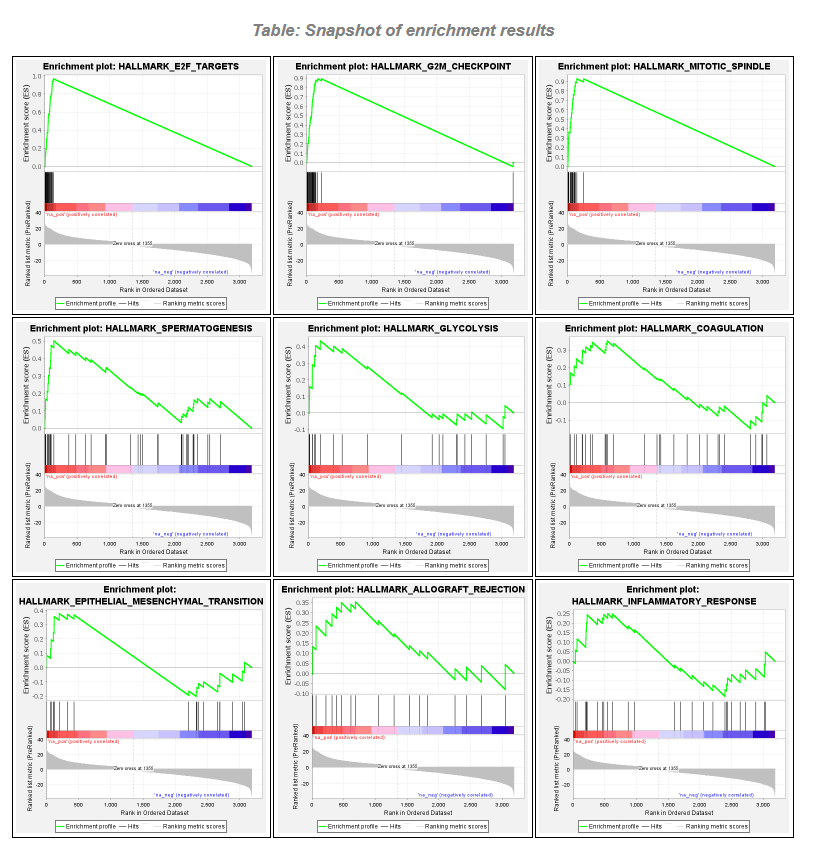

#### Potential biomarkers for early stage (coagulation pathway)

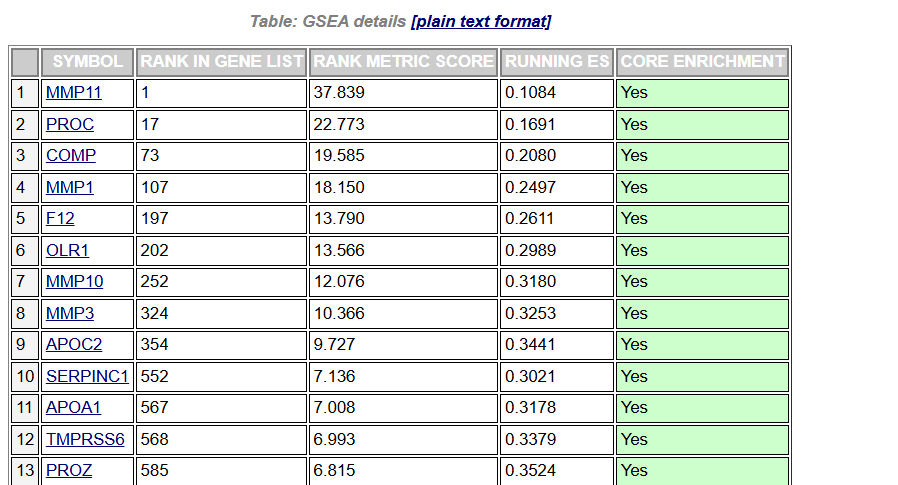

#### Stage 1 samples vs solid normal samples: Negatively enriched pathways

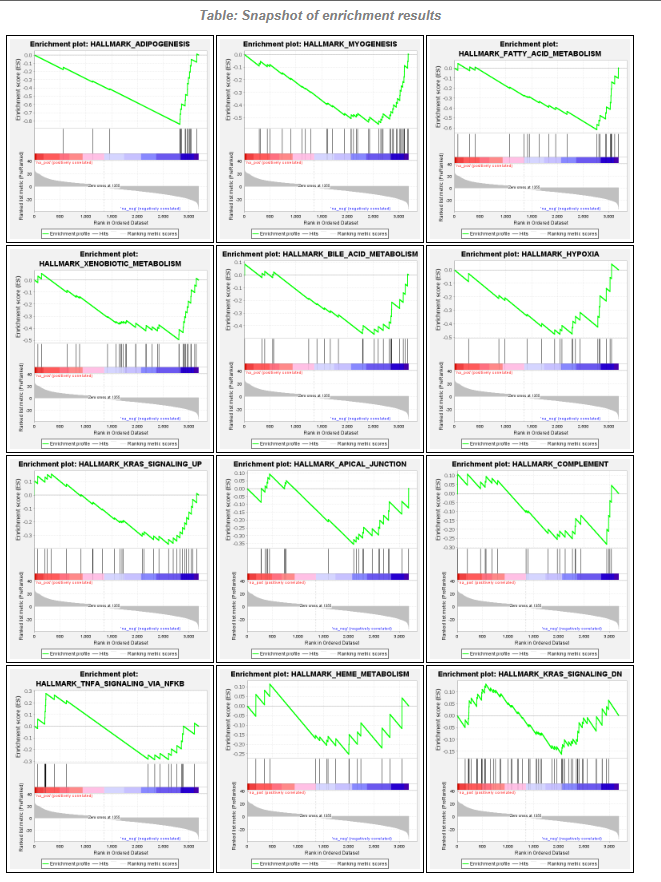

### Classical ML models for feature selection

In [96]:
for x in tcga.iloc[:, 20531:].columns:
    print(tcga[x].value_counts())
    print("----------------------------------")

cancer type abbreviation
0    1215
Name: count, dtype: int64
----------------------------------
age_at_initial_pathologic_diagnosis
62.000000    55
63.000000    42
56.000000    38
58.000000    36
50.000000    36
             ..
58.242998     1
86.000000     1
33.000000     1
28.000000     1
27.000000     1
Name: count, Length: 66, dtype: int64
----------------------------------
gender
0    1202
1      13
Name: count, dtype: int64
----------------------------------
race
0    867
1    189
2     93
3     62
4      3
5      1
Name: count, dtype: int64
----------------------------------
ajcc_pathologic_tumor_stage
2     359
0     260
4     155
14    113
8      90
9      86
1      67
3      27
6      20
7      13
5       6
10      6
11      6
13      5
12      2
Name: count, dtype: int64
----------------------------------
histological_type
0    882
1    210
2     47
4     39
3     18
7      9
6      8
5      1
8      1
Name: count, dtype: int64
----------------------------------
initial_path

In [97]:
tcga= tcga.drop(columns=["ajcc_pathologic_tumor_stage"])

In [98]:
tcga

,ARHGEF10L,HIF3A,RNF17,RNF10,RNF11,RNF13,GTF2IP1,REM1,MTVR2,RTN4RL2,...,DSS.time,DFI,DFI.time,PFI,PFI.time,Redaction,sample_type_id,sample_type,_primary_disease,combined_stage
samples,,,,,,,,,,,,,,,,,,,,,
TCGA-E2-A15K-06,9.5115,2.2342,0.0000,11.9525,11.1009,10.1532,13.1496,3.6768,0.0000,6.6778,...,275.0,0.000000,275.000000,0.0,275.0,0,6.0,0,0,0
TCGA-AC-A6IX-06,9.8322,5.5864,0.6543,11.8572,11.4146,10.7002,12.6255,5.4699,0.6543,6.6393,...,373.0,0.000000,373.000000,0.0,373.0,0,6.0,0,0,1
TCGA-BH-A18V-06,10.3288,9.0009,1.1120,11.4478,10.4904,10.5517,12.9269,3.8142,0.6606,5.1868,...,1556.0,0.000000,1556.000000,0.0,1556.0,0,6.0,0,0,0
TCGA-E2-A15A-06,9.2990,2.0152,0.3833,11.8497,10.4959,10.0438,12.6822,4.8114,0.0000,4.0459,...,710.0,0.000000,710.000000,0.0,710.0,0,6.0,0,0,1
TCGA-E2-A15E-06,9.3333,3.8639,0.0000,11.9488,11.5201,10.1137,12.5709,4.1040,0.0000,4.3897,...,630.0,0.000000,630.000000,0.0,630.0,0,6.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-A7-A26E-01,9.6430,3.2869,0.0000,12.0723,11.7878,10.5635,12.7208,3.0760,0.6144,4.1038,...,954.0,0.000000,954.000000,0.0,954.0,0,1.0,1,0,1
TCGA-A7-A13E-01,10.7570,3.0461,0.0000,11.1565,10.7619,10.3025,12.9691,5.2856,0.0000,7.6592,...,614.0,1.000000,556.000000,1.0,556.0,0,1.0,1,0,0
TCGA-A7-A0DB-01,9.4012,3.9239,0.0000,11.9896,11.4222,10.7523,12.7633,3.5041,0.0000,6.0723,...,1007.0,0.087669,1172.677917,0.0,1007.0,0,1.0,1,0,0


#### Method 1: Binary target

In [114]:
y=tcga["combined_stage"]
stage_mapping = {v: k for k, v in categorical_mappings["combined_stage"].items()}
y_decoded = y.map(stage_mapping)

In [115]:
tcga["combined_stage"]= y_decoded

In [53]:
new_df= tcga[tcga["combined_stage"].isin(["Stage I", "Normal"])]

In [54]:
new_df

,ARHGEF10L,HIF3A,RNF17,RNF10,RNF11,RNF13,GTF2IP1,REM1,MTVR2,RTN4RL2,...,DSS.time,DFI,DFI.time,PFI,PFI.time,Redaction,sample_type_id,sample_type,_primary_disease,combined_stage
samples,,,,,,,,,,,,,,,,,,,,,
TCGA-A8-A08A-01,9.8786,0.4455,0.0000,11.9033,10.9511,9.9164,12.6493,2.2073,0.0000,6.0784,...,30.0,0.000000,30.000000,0.0,30.0,0,1.0,1,0,Stage I
TCGA-E2-A15O-01,9.3760,0.8672,0.0000,12.4611,10.7180,9.0355,13.4042,2.7589,0.4978,3.6482,...,1545.0,1.000000,1210.000000,1.0,1210.0,0,1.0,1,0,Stage I
TCGA-BH-A1FG-01,10.2439,1.6713,0.0000,12.0515,11.3830,11.3950,12.5189,3.9604,0.4481,5.3207,...,3736.0,0.087669,1172.677917,0.0,3736.0,0,1.0,1,0,Stage I
TCGA-BH-A8FY-01,9.8860,2.5831,0.0000,12.0487,10.6782,9.7698,12.6934,4.8166,0.0000,4.8448,...,295.0,0.000000,295.000000,0.0,295.0,0,1.0,1,0,Stage I
TCGA-E9-A54X-01,8.3141,1.3159,0.0000,12.0865,11.8970,10.5531,13.0418,2.5766,0.0000,4.5450,...,727.0,0.000000,727.000000,0.0,727.0,0,1.0,1,0,Stage I
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-A7-A0D9-11,9.5692,9.3537,0.0000,11.9178,11.9225,10.8396,12.6587,6.2643,0.0000,3.8317,...,1139.0,0.000000,1139.000000,0.0,1139.0,0,11.0,2,0,Normal
TCGA-BH-A1FN-11,9.2609,7.6353,0.0000,11.7187,11.5151,11.1673,12.6550,5.3089,0.6569,4.7677,...,2192.0,0.087669,1172.677917,1.0,2192.0,0,11.0,2,0,Normal
TCGA-BH-A0HA-11,10.6813,7.1427,0.0000,11.5149,11.1492,10.8266,12.7275,4.5171,0.4911,3.4239,...,1611.0,0.000000,1611.000000,0.0,1611.0,0,11.0,2,0,Normal


In [55]:
new_df['combined_stage'] = new_df['combined_stage'].map({'Normal': 0, 'Stage I': 1})

C:\Users\Neermita Bhattachary\AppData\Local\Temp\ipykernel_6204\3196489016.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['combined_stage'] = new_df['combined_stage'].map({'Normal': 0, 'Stage I': 1})


In [56]:
X= new_df.iloc[:, :20530]

In [57]:
X

,ARHGEF10L,HIF3A,RNF17,RNF10,RNF11,RNF13,GTF2IP1,REM1,MTVR2,RTN4RL2,...,TULP2,NPY5R,GNGT2,GNGT1,TULP3,PTRF,BCL6B,GSTK1,SELP,SELS
samples,,,,,,,,,,,,,,,,,,,,,
TCGA-A8-A08A-01,9.8786,0.4455,0.0000,11.9033,10.9511,9.9164,12.6493,2.2073,0.0000,6.0784,...,0.0000,1.4901,4.2272,0.0000,8.7631,11.9386,7.9251,12.0569,4.6577,9.8081
TCGA-E2-A15O-01,9.3760,0.8672,0.0000,12.4611,10.7180,9.0355,13.4042,2.7589,0.4978,3.6482,...,0.4978,10.7341,3.6000,3.1423,9.9240,11.0286,7.3262,10.5413,6.3534,10.2369
TCGA-BH-A1FG-01,10.2439,1.6713,0.0000,12.0515,11.3830,11.3950,12.5189,3.9604,0.4481,5.3207,...,0.0000,0.4481,3.5759,0.0000,8.8127,10.7197,7.5671,11.4650,5.6168,11.1774
TCGA-BH-A8FY-01,9.8860,2.5831,0.0000,12.0487,10.6782,9.7698,12.6934,4.8166,0.0000,4.8448,...,0.6366,9.1396,4.5694,0.0000,9.2343,11.0727,8.1521,12.3786,7.1260,10.2285
TCGA-E9-A54X-01,8.3141,1.3159,0.0000,12.0865,11.8970,10.5531,13.0418,2.5766,0.0000,4.5450,...,0.0000,3.8486,0.5816,0.0000,9.3287,8.8464,5.4164,11.1384,1.8002,11.2900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-A7-A0D9-11,9.5692,9.3537,0.0000,11.9178,11.9225,10.8396,12.6587,6.2643,0.0000,3.8317,...,1.3377,7.8778,4.0246,0.0000,9.5979,15.6531,9.4835,11.3607,9.5624,9.6880
TCGA-BH-A1FN-11,9.2609,7.6353,0.0000,11.7187,11.5151,11.1673,12.6550,5.3089,0.6569,4.7677,...,1.4490,3.9995,5.1771,0.0000,9.8558,13.3340,9.7836,11.1799,10.5705,9.7115
TCGA-BH-A0HA-11,10.6813,7.1427,0.0000,11.5149,11.1492,10.8266,12.7275,4.5171,0.4911,3.4239,...,1.7795,3.7187,3.7187,0.0000,9.6036,13.2154,7.0921,11.0640,7.4137,9.2804


In [58]:
y=new_df["combined_stage"]

In [59]:
y

samples
TCGA-A8-A08A-01    1
TCGA-E2-A15O-01    1
TCGA-BH-A1FG-01    1
TCGA-BH-A8FY-01    1
TCGA-E9-A54X-01    1
                  ..
TCGA-A7-A0D9-11    0
TCGA-BH-A1FN-11    0
TCGA-BH-A0HA-11    0
TCGA-BH-A1FE-11    0
TCGA-BH-A0DG-11    0
Name: combined_stage, Length: 295, dtype: int64

In [64]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


In [140]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [141]:
X_train

,ARHGEF10L,HIF3A,RNF17,RNF10,RNF11,RNF13,GTF2IP1,REM1,MTVR2,RTN4RL2,...,TULP2,NPY5R,GNGT2,GNGT1,TULP3,PTRF,BCL6B,GSTK1,SELP,SELS
samples,,,,,,,,,,,,,,,,,,,,,
TCGA-E2-A1IJ-01,9.8606,1.5493,0.0000,12.0093,11.1076,10.4773,12.3719,4.6671,0.0000,6.1102,...,0.7157,0.7157,4.7382,0.0000,9.3535,13.4343,8.9472,11.0379,8.6317,9.7455
TCGA-BH-A208-11,10.2535,6.4730,0.0000,11.4722,11.2954,10.9711,12.3574,3.8494,0.7126,4.0295,...,1.9540,4.1118,3.4881,0.0000,9.5623,13.3931,7.0121,10.9259,7.1835,9.7339
TCGA-GI-A2C8-11,11.4655,7.1927,2.2077,13.3639,12.3311,10.6249,12.1582,6.1352,0.0000,3.7452,...,1.0244,3.2913,3.0425,0.0000,8.1062,13.0824,9.1009,11.5277,7.3008,9.5261
TCGA-BH-A18M-11,9.7540,8.7564,2.1782,11.7744,11.5930,10.5854,12.5516,5.5359,0.9118,4.8014,...,1.8656,6.3746,3.6892,0.0000,9.7250,14.1819,9.7825,11.0766,9.0302,9.2684
TCGA-GM-A2DO-01,10.1205,3.3013,1.9829,11.7921,10.2191,10.2923,12.5172,5.5012,0.9886,3.8855,...,0.0000,0.9886,5.9547,0.0000,8.3259,10.7033,7.1671,12.3833,7.5164,10.4417
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-BH-A0HB-01,9.8510,1.5425,0.0000,12.4752,11.3772,10.6458,12.6051,3.6955,0.9683,5.6095,...,0.0000,5.7314,4.3982,0.0000,8.0048,11.9629,7.0604,11.1979,7.0184,10.7102
TCGA-E2-A1II-01,9.1870,5.4853,0.0000,12.5989,10.8347,10.8592,12.4661,7.4307,1.3585,1.8508,...,0.0000,1.0305,5.7597,0.0000,10.4250,9.7538,7.0486,11.4341,6.5911,9.2855
TCGA-A7-A26F-01,9.0091,1.7592,0.7787,11.9855,12.7722,10.2357,12.7579,3.6101,0.0000,2.7997,...,0.0000,0.0000,4.8172,0.0000,9.6767,11.9814,7.9282,10.6047,6.4721,9.3979


In [142]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [143]:
X_train_scaled

array([[ 0.24569683, -1.10066015, -0.42931288, ..., -0.29363947,
         0.58539619, -0.44646847],
       [ 0.8897718 ,  0.59656408, -0.42931288, ..., -0.50275806,
        -0.15050916, -0.46891426],
       [ 2.87658489,  0.8446483 ,  2.51241651, ...,  0.62088095,
        -0.09090296, -0.87100359],
       ...,
       [-1.15015412, -1.02830656,  0.60829398, ..., -1.10248031,
        -0.51200831, -1.11906832],
       [-0.63787764, -0.69628666,  0.30701889, ...,  0.27042059,
         0.45571586, -0.07649985],
       [ 0.61715875,  0.62420942, -0.42931288, ...,  1.9041596 ,
         0.7408398 ,  3.0113449 ]])

In [158]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_scaled, y_train)
y_pred = rf.predict(X_test_scaled)
y_proba = rf.predict_proba(X_test_scaled)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9830508474576272
ROC-AUC: 0.9981884057971016

Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98        23
           1       1.00      0.97      0.99        36

    accuracy                           0.98        59
   macro avg       0.98      0.99      0.98        59
weighted avg       0.98      0.98      0.98        59



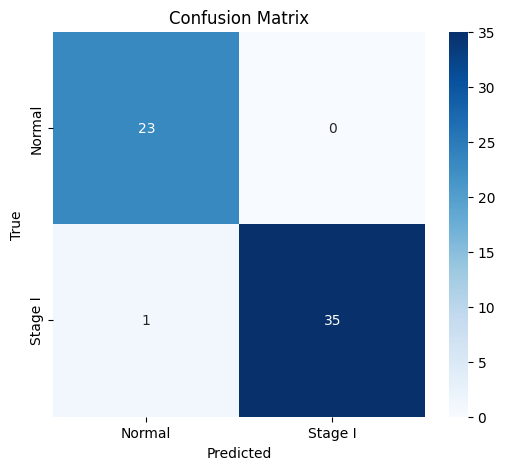

In [154]:

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Stage I'], yticklabels=['Normal', 'Stage I'])
plt.title("Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

       Feature  Importance
16346    FXYD1    0.018715
20037   CORO2B    0.018255
8183     PROS1    0.018149
7595    SYNPO2    0.017096
17584    CEP68    0.016719
18428   PLSCR4    0.015527
19058   MAMDC2    0.011636
752      TSHZ2    0.010786
13168     IL33    0.010240
16944  TMEM220    0.010151


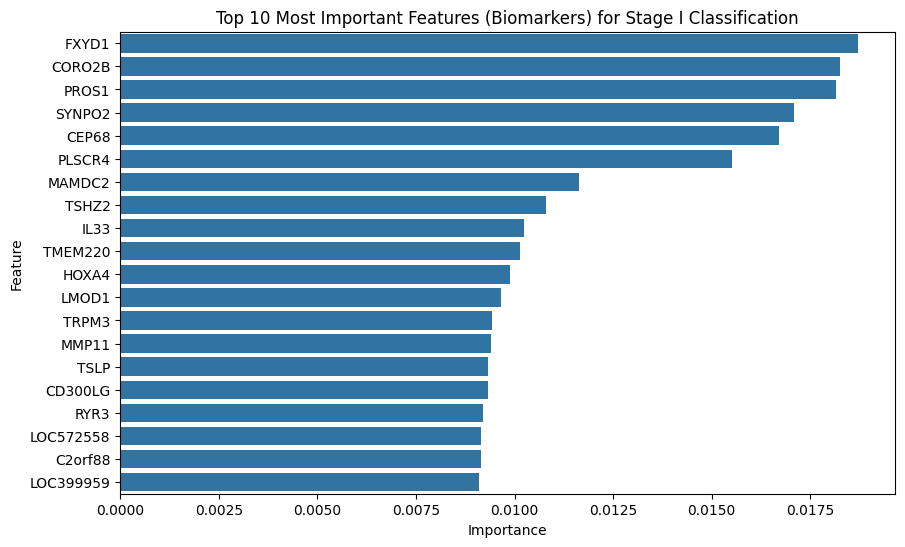

In [157]:



feature_importances = rf.feature_importances_
importance_df = pd.DataFrame({'Feature': X_train.columns,'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)


print(importance_df.head(10))


plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
plt.title("Top 10 Most Important Features (Biomarkers) for Stage I Classification")
plt.show()


In [145]:
pip install shap

Note: you may need to restart the kernel to use updated packages.


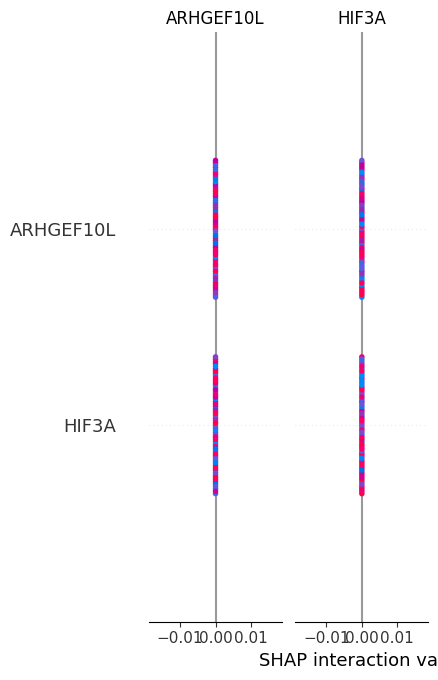

In [152]:
import shap

# Create SHAP explainer for binary classification
explainer = shap.TreeExplainer(rf)

# Compute SHAP values
shap_values = explainer.shap_values(X_test_scaled)

# For binary classification, shap_values is a list with two arrays (for classes 0 and 1).
# Use shap_values[1] for positive class predictions.
if isinstance(shap_values, list):
    shap_values_to_plot = shap_values[1]
else:
    shap_values_to_plot = shap_values

# Summary plot
shap.summary_plot(shap_values_to_plot, X_test_scaled, feature_names=X.columns)



### RF trained on significant genes

In [51]:
significant_genes = stage1_vs_normal['Feature'].tolist()

In [52]:
significant_genes

['MMP11',
 'COL10A1',
 'IBSP',
 'NEK2',
 'BMP8A',
 'KIAA0101',
 'HSD17B6',
 'PKMYT1',
 'UBE2T',
 'PPAPDC1A',
 'KIF4A',
 'GABRD',
 'UHRF1',
 'NUF2',
 'CDK1',
 'SPC25',
 'COL11A1',
 'ASF1B',
 'CDCA8',
 'UBE2C',
 'IQGAP3',
 'TPX2',
 'AURKA',
 'ESM1',
 'GPRIN1',
 'HJURP',
 'CILP2',
 'MMP13',
 'CLEC5A',
 'CDKN3',
 'CDC25C',
 'PLK1',
 'HAGHL',
 'TROAP',
 'KIFC1',
 'CCDC64',
 'KIF2C',
 'PROC',
 'WDR62',
 'NUSAP1',
 'COMP',
 'CCNE2',
 'MELK',
 'NDC80',
 'CST1',
 'LOC283867',
 'KIF18B',
 'RECQL4',
 'FOXM1',
 'CEP55',
 'C16orf59',
 'WISP1',
 'PTTG1',
 'NCAPG',
 'SKA3',
 'BUB1B',
 'PBK',
 'CCNB2',
 'CDCA5',
 'CDCA3',
 'HMMR',
 'PRR19',
 'OIP5',
 'KIF20A',
 'DLGAP5',
 'CDC20',
 'SKA1',
 'DTL',
 'RRM2',
 'AURKB',
 'RPLP0P2',
 'ANLN',
 'CENPM',
 'FAM54A',
 'TOP2A',
 'BUB1',
 'RAD51',
 'CNIH2',
 'ASPM',
 'CCL11',
 'CHRNA6',
 'CKAP2L',
 'GTSE1',
 'NEIL3',
 'ERCC6L',
 'CTXN1',
 'EPR1',
 'RAD54L',
 'EXO1',
 'CST4',
 'SPC24',
 'SAMD14',
 'TDO2',
 'GJB2',
 'KIF14',
 'INHBA',
 'NCAPH',
 'ADAMTS14',
 'EME1'

In [61]:
X_sig = X.loc[:, significant_genes]

In [62]:
X_sig

,MMP11,COL10A1,IBSP,NEK2,BMP8A,KIAA0101,HSD17B6,PKMYT1,UBE2T,PPAPDC1A,...,TSLP,TMEM220,CD300LG,MME,HOXA4,MAMDC2,SDPR,FIGF,SCN4B,ADAMTS5
samples,,,,,,,,,,,,,,,,,,,,,
TCGA-A8-A08A-01,14.0201,12.1031,7.0242,8.4414,8.3074,8.1641,6.2252,8.1949,8.1641,8.0913,...,0.4455,6.1898,2.4173,7.9100,5.5399,3.8467,5.0843,1.2912,5.9660,7.5042
TCGA-E2-A15O-01,12.4355,9.7283,1.7959,9.1223,8.2097,8.9419,7.8280,9.8674,8.7439,5.5209,...,3.0734,4.3187,3.3893,7.1903,3.8222,5.3399,5.5966,2.1032,5.5079,5.9346
TCGA-BH-A1FG-01,11.8765,10.1462,3.8186,7.6348,6.1407,8.0774,5.3207,7.9885,6.6911,5.6898,...,2.4249,5.1972,3.9262,6.8858,3.8540,5.1829,6.6706,3.4373,5.7882,5.6693
TCGA-BH-A8FY-01,9.7252,5.7318,5.4682,7.8321,7.4281,9.1953,4.6672,8.5746,9.1254,1.0768,...,2.2878,5.0519,3.9470,6.4609,6.0413,5.9612,7.2935,2.1138,6.9878,5.4315
TCGA-E9-A54X-01,8.4778,4.4822,5.0346,8.4225,5.6483,9.0906,3.3129,7.6900,8.3029,2.7987,...,0.5816,2.8982,0.0000,2.7987,1.5783,4.1198,2.1621,1.5783,5.8481,4.1999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-A7-A0D9-11,6.8139,3.9314,0.0000,2.7226,4.6690,3.7792,2.3429,1.0562,4.3468,0.5938,...,6.1133,8.2929,11.9927,12.9304,6.2324,9.8754,12.8532,9.5359,10.4131,11.3760
TCGA-BH-A1FN-11,7.9566,3.9465,0.0000,4.7829,5.5676,6.2253,4.8565,4.2135,6.1216,3.1817,...,7.0244,8.1418,8.7960,12.1260,8.2713,9.8705,11.0723,9.4962,9.8693,10.6260
TCGA-BH-A0HA-11,5.0101,1.1483,0.0000,4.9733,6.2406,5.3627,3.2503,4.7658,6.0507,2.3378,...,6.5833,8.5689,9.2267,12.3139,7.9466,10.4963,11.1237,7.7187,10.2483,12.4135


In [72]:
X_train_sig, X_test_sig, y_train_sig, y_test_sig = train_test_split(X_sig, y, test_size=0.2, random_state=42, stratify=y)

In [73]:
scaler = StandardScaler()
X_train_sig_scaled = scaler.fit_transform(X_train_sig)
X_test_sig_scaled = scaler.transform(X_test_sig)

In [74]:
rf_sig = RandomForestClassifier(random_state=42)
rf_sig.fit(X_train_sig_scaled, y_train_sig)

y_pred_sig = rf_sig.predict(X_test_sig_scaled)
y_proba_sig = rf_sig.predict_proba(X_test_sig_scaled)[:, 1]

print("Accuracy (Significant Genes):", accuracy_score(y_test_sig, y_pred_sig))
print("ROC-AUC (Significant Genes):", roc_auc_score(y_test_sig, y_proba_sig))
print("\nClassification Report (Significant Genes):\n", classification_report(y_test_sig, y_pred_sig))

Accuracy (Significant Genes): 0.9830508474576272
ROC-AUC (Significant Genes): 1.0

Classification Report (Significant Genes):
               precision    recall  f1-score   support

           0       0.96      1.00      0.98        23
           1       1.00      0.97      0.99        36

    accuracy                           0.98        59
   macro avg       0.98      0.99      0.98        59
weighted avg       0.98      0.98      0.98        59



In [68]:
0.9830508474576272

0.9830508474576272

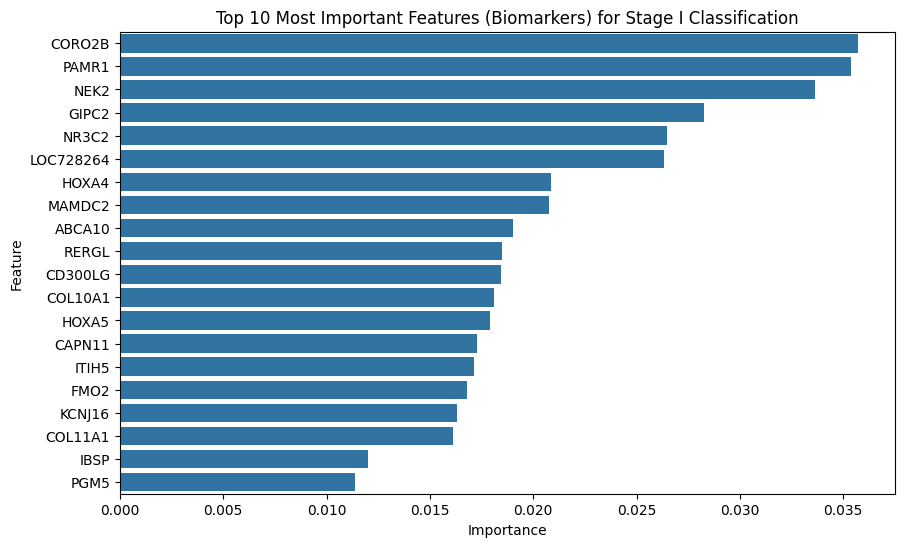

In [75]:
feature_importances_sig = rf_sig.feature_importances_
importance_df_sig = pd.DataFrame({'Feature': X_train_sig.columns,'Importance': feature_importances_sig})
importance_df_sig = importance_df_sig.sort_values(by='Importance', ascending=False)


plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df_sig.head(20))
plt.title("Top 10 Most Important Features (Biomarkers) for Stage I Classification")
plt.show()